# Loading Dataset

You can download the dataset from {https://darwin.v7labs.com/v7-labs/covid-19-chest-x-ray-dataset?sort=priority\%3Adesc}.
The data entitled as '`darwin dataset pull v7-labs/covid-19-chest-x-ray-dataset:all-images`' will be used in this assignment. All dataset consist of 6504 images from 702 classes. We will extract the images of 4 classes (Bacterial Pneumonia, Viral Pneumonia, No Pneumonia (healthy), Covid-19) and save them as .npy file with the following code:

In [2]:
# Connect to drive to access the data 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# import packages
from google.colab import drive
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import layers, models
from keras.utils import to_categorical
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt
from itertools import cycle
import scikitplot as skplt
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight

In [4]:
# Load the data and labels
data = np.load('/content/drive/MyDrive/Colab_Notebooks/data_new.npy')
labels = np.load('/content/drive/MyDrive/Colab_Notebooks/labels_new.npy')

In [5]:
# Check length labels and data
print(len(data))
print(np.unique(labels))

6913
['Bacterial Pneumonia' 'COVID-19' 'No Pneumonia (healthy)'
 'Viral Pneumonia']


# Preprocessing Steps



In [6]:
# Split data into Train, Test, Val set with ratio 0.2
X_trainval, X_test, y_trainval, y_test = train_test_split(data, labels, test_size = 0.2, stratify=labels, random_state = 1)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.25, stratify=y_trainval, random_state = 42)

In [7]:
# Check the ratios after split
print("Train Ratio:", round(len(X_train)/ len(data),1)*100, "%")
print("Test Ratio:", round(len(X_test)/ len(data),2)*100, "%")
print("Val Ratio:", round(len(X_val)/ len(data),2)*100, "%")

Train Ratio: 60.0 %
Test Ratio: 20.0 %
Val Ratio: 20.0 %


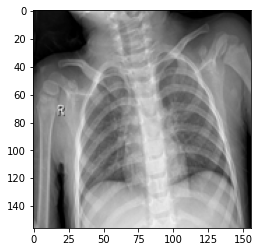

In [8]:
# Visualize data 
plt.imshow(X_train[0])

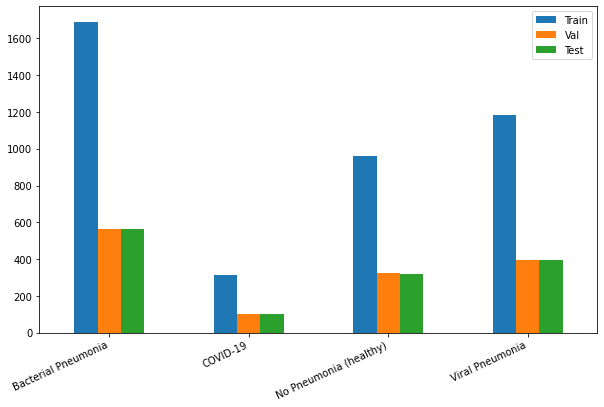

In [9]:
labels, train_counts = np.unique(y_train, return_counts=True)
_, val_counts = np.unique(y_val, return_counts=True)
_, test_counts = np.unique(y_test, return_counts=True)
pd.DataFrame({'Train':train_counts,
             'Val':val_counts,
             'Test':test_counts},
             index=labels
             ).plot.bar(figsize=(10,6))
plt.xticks(rotation=25, ha="right")
plt.show()

## Normalize Data

We know that the pixel values for each image in the dataset are unsigned integers in the range between no color and full color, or 0 and 255. So, we need to normalize the pixel values, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

In [10]:
# Convert from integers to floats
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

In [11]:
# Normalize to range 0-1
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

First we convert the labels to a numerical value. Then we one-hot encode the numerical values

In [12]:
# Convert class labels to integer labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [13]:
# Convert integer labels to one-hot encoded vectors
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Create Baseline Model

In [13]:
# Create CNN baseline model
model = keras.Sequential(
    [
        layers.Conv2D(64, (3, 3), activation="relu", input_shape= X_train.shape[1:], padding='same'),
        layers.Conv2D(32, (3, 3), activation="relu", padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu", padding='same'),
        layers.Conv2D(32, (3, 3), activation="relu", padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(32, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(4, activation="softmax"),
    ]
)

# Compile the model
model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Print summary of model to check architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 156, 156, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 156, 156, 32)      18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 78, 78, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 78, 78, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 78, 78, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                    

In [14]:
# Train the baseline model
history = model.fit(
    X_train, 
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
)

# Evalutate model
print("Test Loss and Accuracy:")
test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/10
130/130 [==============================] - 23s 79ms/step - loss: 1.0373 - accuracy: 0.5303 - val_loss: 0.7870 - val_accuracy: 0.6486
Epoch 2/10
130/130 [==============================] - 9s 68ms/step - loss: 0.6924 - accuracy: 0.6880 - val_loss: 0.6874 - val_accuracy: 0.6898
Epoch 3/10
130/130 [==============================] - 8s 64ms/step - loss: 0.6415 - accuracy: 0.7140 - val_loss: 0.6790 - val_accuracy: 0.6941
Epoch 4/10
130/130 [==============================] - 9s 69ms/step - loss: 0.5912 - accuracy: 0.7314 - val_loss: 0.6194 - val_accuracy: 0.7064
Epoch 5/10
130/130 [==============================] - 9s 71ms/step - loss: 0.5510 - accuracy: 0.7562 - val_loss: 0.6079 - val_accuracy: 0.7281
Epoch 6/10
130/130 [==============================] - 8s 63ms/step - loss: 0.5136 - accuracy: 0.7581 - val_loss: 0.6089 - val_accuracy: 0.7129
Epoch 7/10
130/130 [==============================] - 8s 64ms/step - loss: 0.4687 - accuracy: 0.7767 - val_loss: 0.6087 - val_accuracy: 0.725

#### Plot of training and validation curves

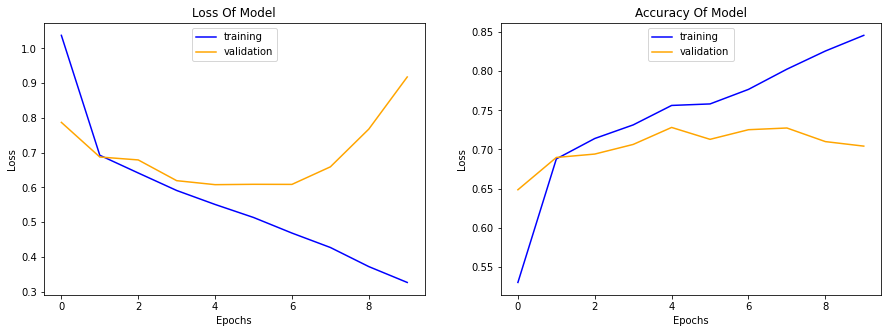

In [15]:
# plot of training and validation curves
def summarize_diagnostics(history):
	# plot loss
	plt.figure(figsize = (15,5))
	plt.subplot(121)
	plt.title('Loss Of Model')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.legend(['training', 'validation'], loc='upper center')
	# plot accuracy
	plt.subplot(122)
	plt.title('Accuracy Of Model')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	plt.legend(['training', 'validation'],loc='upper center')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.show()
 
summarize_diagnostics(history)

#### Classification Reports



In [16]:
# make prediction on test_data
test_pred = model.predict(X_test) 
# make predicton on validation data
val_pred = model.predict(X_val) 

44/44 [==============================] - 1s 15ms/step


In [17]:
# Classification report validation dataset
class_report = classification_report(np.argmax(y_val, axis=1), val_pred.argmax(axis=1))
print("Classification_report of validation dataset\n")
print(class_report)
print()



Classification_report of validation dataset

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       563
           1       0.11      0.04      0.06       104
           2       0.84      0.91      0.88       322
           3       0.52      0.56      0.54       394

    accuracy                           0.70      1383
   macro avg       0.57      0.58      0.57      1383
weighted avg       0.68      0.70      0.69      1383




In [18]:
# Classification report test set
class_report = classification_report(np.argmax(y_test, axis=1), test_pred.argmax(axis=1))
print("Classification_report of test dataset\n")
print(class_report)

Classification_report of test dataset

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       564
           1       0.11      0.03      0.05       104
           2       0.84      0.92      0.88       321
           3       0.56      0.56      0.56       394

    accuracy                           0.72      1383
   macro avg       0.57      0.59      0.57      1383
weighted avg       0.68      0.72      0.70      1383



#### ROC curves and AUC Score

auc score of validation dataset = 0.9015867352158653


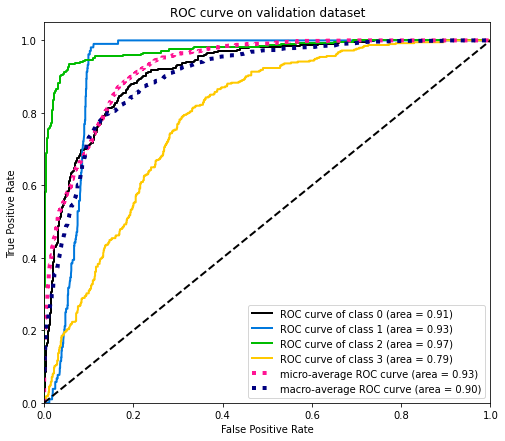


auc score of test dataset = 0.898487286434321


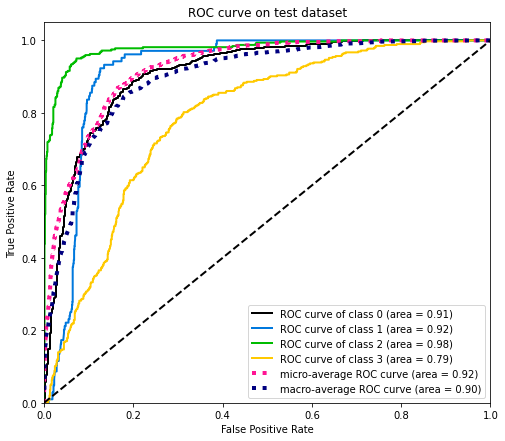

In [19]:
# Area under the Curve score Validation set
auc_score = roc_auc_score(y_val, val_pred,  multi_class = 'ovo') 
print('\033[0m' + 'auc score of validation dataset =',auc_score) 

skplt.metrics.plot_roc(np.argmax(y_val, axis=1), val_pred, figsize = (8,7))
plt.title ("ROC curve on validation dataset")
plt.show()
print()

# Area under the Curve score Test set
auc_score = roc_auc_score(y_test, test_pred,  multi_class = 'ovo') 
print('\033[0m' + 'auc score of test dataset =',auc_score) 

skplt.metrics.plot_roc(np.argmax(y_test, axis=1), test_pred, figsize = (8,7))
plt.title ("ROC curve on test dataset")
plt.show()



#### Confusion Matrix

Confusion Matrix Validation


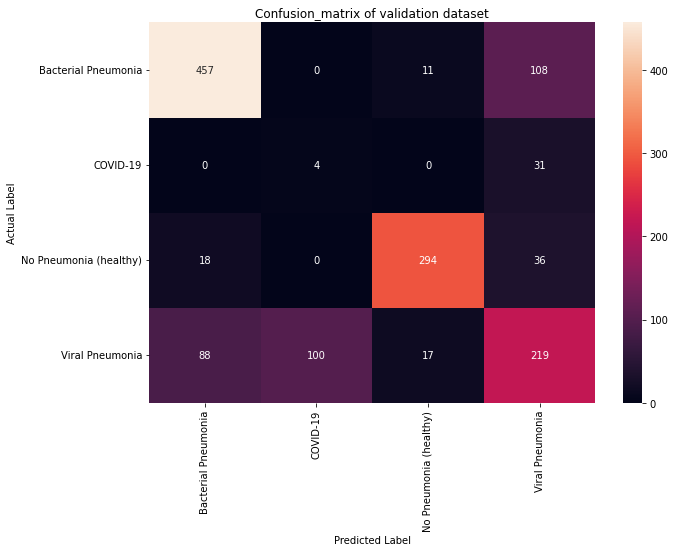

Confusion Matrix Test


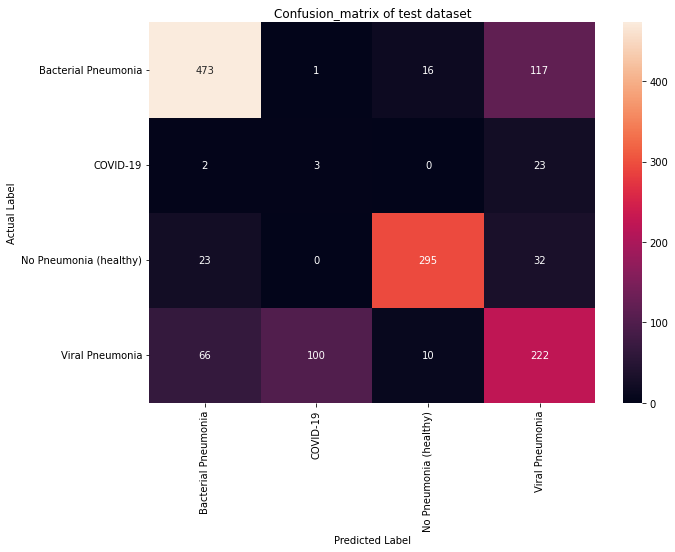

In [20]:
# Confusion matrix validation set
print('\033[1m' + "Confusion Matrix Validation")
labels = ['Bacterial Pneumonia' 'COVID-19' 'No Pneumonia (healthy)'
 'Viral Pneumonia']
plt.figure(figsize = (10,7))
cm_val = confusion_matrix(val_pred.argmax(axis=1), np.argmax(y_val, axis=1))
plt.title("Confusion_matrix of validation dataset")
sns.heatmap(cm_val, annot = True, fmt='d')
locs, labels = plt.xticks() 
plt.xticks([0.5, 1.5, 2.5,3.5], ['Bacterial Pneumonia', 'COVID-19', 'No Pneumonia (healthy)',
 'Viral Pneumonia'], rotation=90) 
plt.yticks([0.5, 1.5, 2.5,3.5], ['Bacterial Pneumonia', 'COVID-19', 'No Pneumonia (healthy)',
 'Viral Pneumonia'], rotation=0) 
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

# Confusion matrix test set
print('\033[1m' + "Confusion Matrix Test")
plt.figure(figsize = (10,7))
plt.title ("Confusion_matrix of test dataset")
cm_test = confusion_matrix(test_pred.argmax(axis=1), np.argmax(y_test, axis=1))
sns.heatmap(cm_test, annot = True, fmt='d')
locs, labels = plt.xticks() 
plt.xticks([0.5, 1.5, 2.5,3.5], ['Bacterial Pneumonia', 'COVID-19', 'No Pneumonia (healthy)',
 'Viral Pneumonia'], rotation=90) 
plt.yticks([0.5, 1.5, 2.5,3.5], ['Bacterial Pneumonia', 'COVID-19', 'No Pneumonia (healthy)',
 'Viral Pneumonia'], rotation=0) 
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

#### Specificity Validation and Test set 


In [21]:
target_names = ['Bacterial Pneumonia', 'COVID-19', 'No Pneumonia (healthy)',
 'Viral Pneumonia']
print("Specificity Val set")
print()
for c in range(len(target_names)):
    tp = cm_val[c,c]
    fp = sum(cm_val[:,c]) - cm_val[c,c]
    fn = sum(cm_val[c,:]) - cm_val[c,c]
    tn = sum(np.delete(sum(cm_val)-cm_val[c,:],c))
    specificity = tn/(tn+fp)
    print("{}:  specificity = {} ".format(target_names[c],round(specificity,4)))



Specificity Val set

Bacterial Pneumonia:  specificity = 0.8686 
COVID-19:  specificity = 0.9258 
No Pneumonia (healthy):  specificity = 0.9729 
Viral Pneumonia:  specificity = 0.8175 


In [22]:
target_names = ['Bacterial Pneumonia', 'COVID-19', 'No Pneumonia (healthy)',
 'Viral Pneumonia']
print("Specificity Test set")
print()
for c in range(len(target_names)):
    tp = cm_test[c,c]
    fp = sum(cm_test[:,c]) - cm_test[c,c]
    fn = sum(cm_test[c,:]) - cm_test[c,c]
    tn = sum(np.delete(sum(cm_test)-cm_test[c,:],c))
    specificity = tn/(tn+fp)
    print("{}:  specificity = {} ".format(target_names[c],round(specificity,4)))



Specificity Test set

Bacterial Pneumonia:  specificity = 0.8827 
COVID-19:  specificity = 0.9255 
No Pneumonia (healthy):  specificity = 0.9748 
Viral Pneumonia:  specificity = 0.8254 


# Adapting/fine-tuning the network

In [13]:
# Create the tuned model
tuned_model = keras.Sequential(
    [
        layers.Conv2D(64, (3, 3), activation="relu", input_shape= X_train.shape[1:], padding='same', strides=1),
        layers.MaxPooling2D((2, 2), padding="same", strides=2),
        layers.Conv2D(64, (3, 3), activation='relu', padding="same", strides=1), 
        layers.MaxPooling2D((2, 2), padding="same", strides=2),
        layers.Conv2D(64, (3, 3), activation='relu', padding="same", strides=1),
        layers.MaxPooling2D((2, 2), padding="same", strides=2),
        layers.Flatten(),
        layers.Dense(neurons, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu',activity_regularizer=regularizers.L2(0.01)),
        layers.Dense(4, activation='softmax') 
    ]
)

# Compile the model
tuned_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

tuned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 156, 156, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 78, 78, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 78, 78, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 39, 39, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 39, 39, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 64)       0

In [14]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,verbose = 1,
                                                 patience=2,
                                                 min_lr=0.00001)
history = tuned_model.fit(X_train, y_train, 
                            epochs=20, 
                            validation_data=(X_val, y_val), 
                            callbacks=[reduce_lr])

Epoch 1/20
130/130 [==============================] - 12s 55ms/step - loss: 1.1449 - accuracy: 0.5358 - val_loss: 0.9113 - val_accuracy: 0.6985 - lr: 0.0010
Epoch 2/20
130/130 [==============================] - 5s 39ms/step - loss: 0.8932 - accuracy: 0.6798 - val_loss: 0.7640 - val_accuracy: 0.7260 - lr: 0.0010
Epoch 3/20
130/130 [==============================] - 5s 38ms/step - loss: 0.8054 - accuracy: 0.7046 - val_loss: 0.7232 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 4/20
130/130 [==============================] - 5s 40ms/step - loss: 0.7328 - accuracy: 0.7246 - val_loss: 0.6760 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 5/20
130/130 [==============================] - 5s 39ms/step - loss: 0.6925 - accuracy: 0.7446 - val_loss: 0.6652 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 6/20
130/130 [==============================] - 5s 38ms/step - loss: 0.6562 - accuracy: 0.7516 - val_loss: 0.6483 - val_accuracy: 0.7281 - lr: 0.0010
Epoch 7/20
130/130 [==============================] - 6s 44ms/s

In [16]:
# Evalutate model niewu 
print("Test Loss and Accuracy:")
test_loss, test_acc = tuned_model.evaluate(X_test, y_test)

Test Loss and Accuracy:
44/44 [==============================] - 1s 23ms/step - loss: 0.6580 - accuracy: 0.7390


#### Classification Reports



In [17]:
# make prediction on test_data
test_pred = tuned_model.predict(X_test) 

44/44 [==============================] - 1s 17ms/step


In [18]:
# Classification report test set
class_report = classification_report(np.argmax(y_test, axis=1), test_pred.argmax(axis=1))
print("Classification_report of test dataset\n")
print(class_report)

Classification_report of test dataset

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       564
           1       0.10      0.02      0.03       104
           2       0.94      0.92      0.93       321
           3       0.56      0.65      0.60       394

    accuracy                           0.74      1383
   macro avg       0.60      0.60      0.59      1383
weighted avg       0.71      0.74      0.72      1383



#### ROC curves and AUC Score

auc score of test dataset = 0.9141610800022941


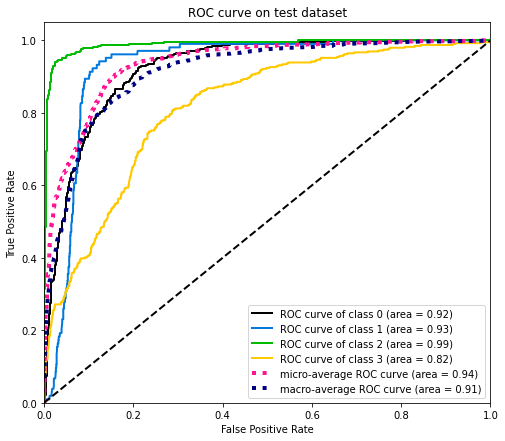

In [19]:
# Area under the Curve score Test set
auc_score = roc_auc_score(y_test, test_pred,  multi_class = 'ovo') 
print('\033[0m' + 'auc score of test dataset =',auc_score) 

skplt.metrics.plot_roc(np.argmax(y_test, axis=1), test_pred, figsize = (8,7))
plt.title ("ROC curve on test dataset")
plt.show()



#### Confusion Matrix

Confusion Matrix Test


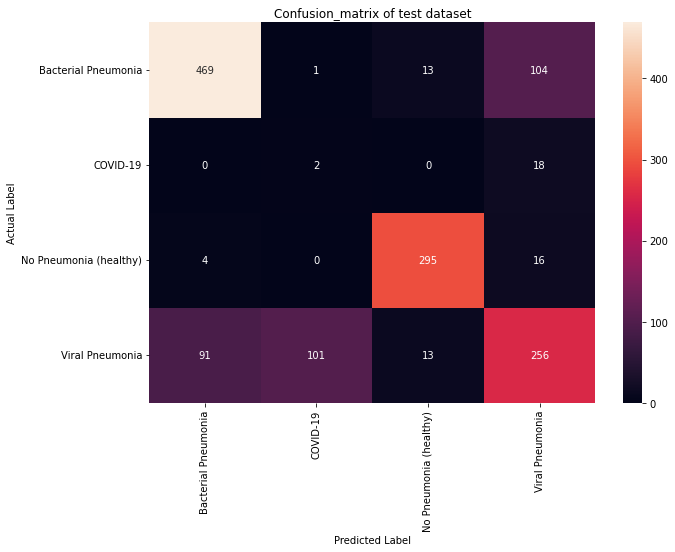

In [20]:
# Confusion matrix test set
print('\033[1m' + "Confusion Matrix Test")
plt.figure(figsize = (10,7))
plt.title ("Confusion_matrix of test dataset")
cm_test = confusion_matrix(test_pred.argmax(axis=1), np.argmax(y_test, axis=1))
sns.heatmap(cm_test, annot = True, fmt='d')
locs, labels = plt.xticks() 
plt.xticks([0.5, 1.5, 2.5,3.5], ['Bacterial Pneumonia', 'COVID-19', 'No Pneumonia (healthy)',
 'Viral Pneumonia'], rotation=90) 
plt.yticks([0.5, 1.5, 2.5,3.5], ['Bacterial Pneumonia', 'COVID-19', 'No Pneumonia (healthy)',
 'Viral Pneumonia'], rotation=0) 
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

#### Specificity Test set 


In [21]:
target_names = ['Bacterial Pneumonia', 'COVID-19', 'No Pneumonia (healthy)',
 'Viral Pneumonia']
print("Specificity test set")
print()
for c in range(len(target_names)):
    tp = cm_test[c,c]
    fp = sum(cm_test[:,c]) - cm_test[c,c]
    fn = sum(cm_test[c,:]) - cm_test[c,c]
    tn = sum(np.delete(sum(cm_test)-cm_test[c,:],c))
    specificity = tn/(tn+fp)
    print("{}:  specificity = {} ".format(target_names[c],round(specificity,4)))



Specificity Val set

Bacterial Pneumonia:  specificity = 0.8807 
COVID-19:  specificity = 0.9252 
No Pneumonia (healthy):  specificity = 0.9757 
Viral Pneumonia:  specificity = 0.8503 


# Transfer Learning

In [14]:
# set the image dimensions and batch size
img_width, img_height = 156, 156
batch_size = 32

# load the VGG16 model with pretrained weights
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# freeze all the layers in the base VGG16 model
for layer in vgg_model.layers:
    layer.trainable = False

# create a new model to add fully connected layers on top of the base VGG16 model
new_model = Sequential()
new_model.add(vgg_model)
new_model.add(Flatten())
new_model.add(Dense(512, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(256, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(4, activation='softmax'))

# compile the model with categorical crossentropy loss and Adam optimizer
new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the new model on the train data and validate on the validation data
epochs = 10
history = new_model.fit(X_train, y_train,
                        epochs=epochs,
                        validation_data=(X_val, y_val))

# evaluate the new model on the test data
test_loss, test_acc = new_model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


Epoch 1/10
130/130 [==============================] - 22s 123ms/step - loss: 0.9982 - accuracy: 0.5889 - val_loss: 0.6264 - val_accuracy: 0.7187
Epoch 2/10
130/130 [==============================] - 14s 105ms/step - loss: 0.7114 - accuracy: 0.6897 - val_loss: 0.6063 - val_accuracy: 0.7339
Epoch 3/10
130/130 [==============================] - 13s 101ms/step - loss: 0.6670 - accuracy: 0.7007 - val_loss: 0.5970 - val_accuracy: 0.7440
Epoch 4/10
130/130 [==============================] - 15s 113ms/step - loss: 0.6393 - accuracy: 0.7179 - val_loss: 0.5849 - val_accuracy: 0.7498
Epoch 5/10
130/130 [==============================] - 12s 96ms/step - loss: 0.6460 - accuracy: 0.6995 - val_loss: 0.5711 - val_accuracy: 0.7346
Epoch 6/10
130/130 [==============================] - 14s 111ms/step - loss: 0.6321 - accuracy: 0.7007 - val_loss: 0.5650 - val_accuracy: 0.7469
Epoch 7/10
130/130 [==============================] - 15s 113ms/step - loss: 0.6333 - accuracy: 0.7109 - val_loss: 0.5614 - val_acc

#### Classification Reports



In [15]:
# make prediction on test_data
test_pred = new_model.predict(X_test) 

44/44 [==============================] - 3s 70ms/step


In [16]:
# Classification report test set
class_report = classification_report(np.argmax(y_test, axis=1), test_pred.argmax(axis=1))
print("Classification_report of test dataset\n")
print(class_report)

Classification_report of test dataset

              precision    recall  f1-score   support

           0       0.76      0.92      0.84       564
           1       0.49      0.53      0.51       104
           2       0.94      0.90      0.92       321
           3       0.65      0.47      0.54       394

    accuracy                           0.76      1383
   macro avg       0.71      0.70      0.70      1383
weighted avg       0.75      0.76      0.75      1383



#### ROC curves and AUC Score

auc score of test dataset = 0.9282131603438034


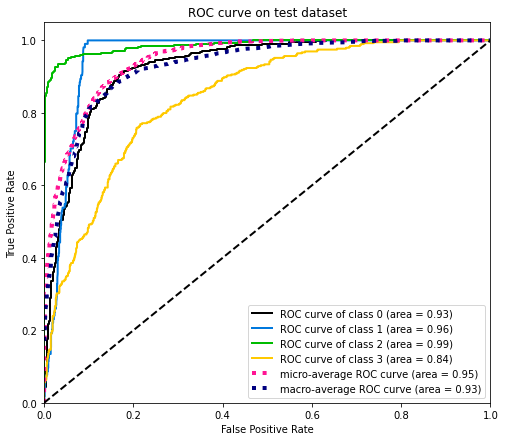

In [17]:
# Area under the Curve score Test set
auc_score = roc_auc_score(y_test, test_pred,  multi_class = 'ovo') 
print('\033[0m' + 'auc score of test dataset =',auc_score) 

skplt.metrics.plot_roc(np.argmax(y_test, axis=1), test_pred, figsize = (8,7))
plt.title ("ROC curve on test dataset")
plt.show()



#### Confusion Matrix

Confusion Matrix Test


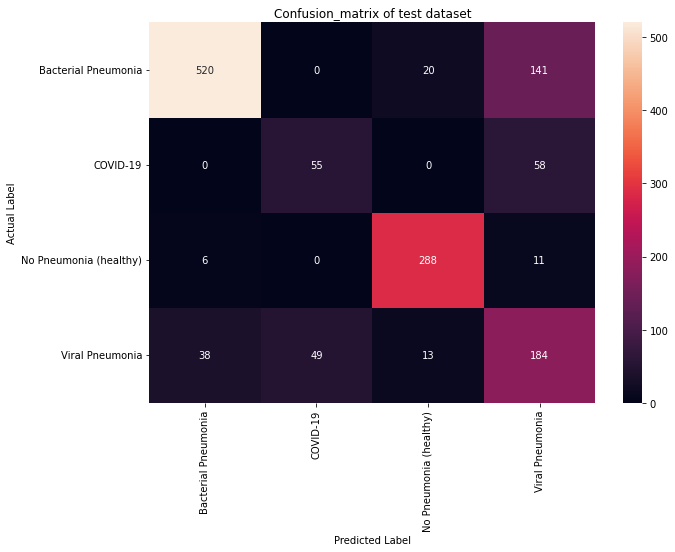

In [18]:
# Confusion matrix test set
print('\033[1m' + "Confusion Matrix Test")
plt.figure(figsize = (10,7))
plt.title ("Confusion_matrix of test dataset")
cm_test = confusion_matrix(test_pred.argmax(axis=1), np.argmax(y_test, axis=1))
sns.heatmap(cm_test, annot = True, fmt='d')
locs, labels = plt.xticks() 
plt.xticks([0.5, 1.5, 2.5,3.5], ['Bacterial Pneumonia', 'COVID-19', 'No Pneumonia (healthy)',
 'Viral Pneumonia'], rotation=90) 
plt.yticks([0.5, 1.5, 2.5,3.5], ['Bacterial Pneumonia', 'COVID-19', 'No Pneumonia (healthy)',
 'Viral Pneumonia'], rotation=0) 
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

#### Specificity Test set 


In [19]:
target_names = ['Bacterial Pneumonia', 'COVID-19', 'No Pneumonia (healthy)',
 'Viral Pneumonia']
print("Specificity Test set")
print()
for c in range(len(target_names)):
    tp = cm_test[c,c]
    fp = sum(cm_test[:,c]) - cm_test[c,c]
    fn = sum(cm_test[c,:]) - cm_test[c,c]
    tn = sum(np.delete(sum(cm_test)-cm_test[c,:],c))
    specificity = tn/(tn+fp)
    print("{}:  specificity = {} ".format(target_names[c],round(specificity,4)))



Specificity Val set

Bacterial Pneumonia:  specificity = 0.9373 
COVID-19:  specificity = 0.9614 
No Pneumonia (healthy):  specificity = 0.9694 
Viral Pneumonia:  specificity = 0.8089 
